# Laboratory #11 : Image Segmentation using UNet

At the end of this laboratory, you would get familiarized with

*   Segmentation using UNet
*   Understand the evaluation metrics
*   Importance of data annotations

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Add sufficient comments and explanations wherever necessary.
*   **Once you have the code completed, use GPU to train model faster.**

---

# **Students** (First Name and Last Name)

1.   Oriol Miró
2.   Marc González

---

# Loading dataset

*   We will use the [Tray Food Segmentation dataset](https://www.kaggle.com/thezaza102/tray-food-segmentation) for this laboratory.
*   You have two options to get the dataset into your notebook
    *   The dataset is already available in campus virtual. Upload the dataset to your drive before starting the exercise.
    *   You can use the kaggle APIs to get the dataset into the notebook directly (Advanced option).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Constants

*   Change the path of the directories according to your drive location.

In [ ]:
import os

root_path = r'/content/drive/MyDrive/test/TrayDataset'

train_img = os.path.join(root_path, 'XTrain')
train_mask = os.path.join(root_path, 'yTrain')
test_img = os.path.join(root_path, 'XTest')
test_mask = os.path.join(root_path, 'yTest')

*   Define the constants needed for training the model

In [ ]:
img_size    = (160, 160)
num_classes = 43  # fixed for this dataset
batch_size  = 32
epochs      = 25

# Paths to Input Images and Segmentation Masks

*   We prepare the list of images and masks for both the train and test set

In [ ]:
import os

train_img_paths = sorted(
    [
        os.path.join(train_img, fname)
        for fname in os.listdir(train_img)
        if fname.endswith(".jpg") or fname.endswith(".JPG")
    ]
)

train_mask_paths = sorted(
    [
        os.path.join(train_mask, fname)
        for fname in os.listdir(train_mask)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

test_img_paths = sorted(
    [
        os.path.join(test_img, fname)
        for fname in os.listdir(test_img)
        if fname.endswith(".jpg") or fname.endswith(".JPG")
    ]
)

test_mask_paths = sorted(
    [
        os.path.join(test_mask, fname)
        for fname in os.listdir(test_mask)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of train samples:", len(train_img_paths))
print("Number of train masks:", len(train_mask_paths))

print("Number of test samples:", len(test_img_paths))
print("Number of test masks:", len(test_mask_paths))

Number of train samples: 1241
Number of train masks: 1241
Number of test samples: 8
Number of test masks: 8


# Visualizing input image and corresponding segmentation mask

*   Visualize one train image and the corresponding segmentation mask in a matplotlib subplot
*   Also, show the mask overlayed on the original image.

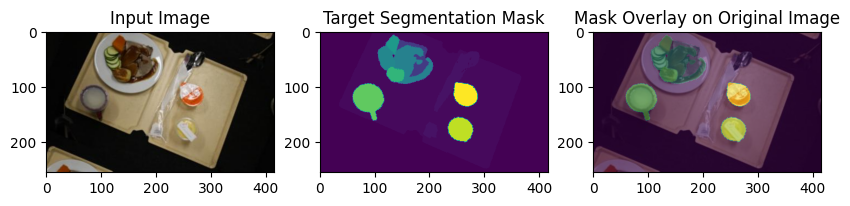

In [ ]:
# solution

# from the tutorial

import matplotlib.pyplot as plt

from tensorflow.keras.utils import load_img
from PIL.ImageOps import autocontrast

import numpy as np

example_index = 5

img = load_img(train_img_paths[example_index])
mask = load_img(train_mask_paths[example_index], color_mode="grayscale")

f, axes = plt.subplots(1, 3, figsize=(10, 20))


axes[0].imshow(img)
axes[0].set_title('Input Image')

axes[1].imshow(mask)
axes[1].set_title('Target Segmentation Mask')

axes[2].imshow(img)
axes[2].imshow(mask, alpha=0.5)
axes[2].set_title('Mask Overlay on Original Image')


plt.show()

# Image Generator

*   Create an image generator class (similar to the tutorial) to iterate over the images and return a tuple corresponding to the batch number.
*   The generator should inherit from the Sequence class.
*   It should have \_\_init\_\_(), \_\_len\_\_() and \_\_getitem\_\_() methods.
*   The batch size, image size, image paths and mask paths should be initialized using the \_\_init\_\_ method.

In [ ]:
# solution

from tensorflow import keras
import numpy as np
from tensorflow.keras.utils import load_img
import math

class ImageGenerator(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        #return len(self.target_img_paths) // self.batch_size ## bug!
        return math.ceil(len(self.target_img_paths) / batch_size)

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y

# U-Net Xception-style model

*   We will use the same model architecture that we followed in the tutorial for this exercise

In [ ]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


In [ ]:
# Free up RAM in case the model definition cells were run multiple times

import keras
keras.backend.clear_session()

In [ ]:
# Build model

model = get_model(img_size, num_classes)

*   Print the summary of the model

In [ ]:
# solution

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 160, 160, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 80, 80, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 80, 80, 32)     │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 80, 80, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 80, 80, 32)     │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 80, 80, 64)     │          2,400 │ activation_1[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 80, 80, 64)     │            256 │ separable_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 80, 80, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 80, 80, 64)     │          4,736 │ activation_2[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 80, 80, 64)     │            256 │ separable_conv2d_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 40, 40, 64)     │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 40, 40, 64)     │          2,112 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 40, 40, 64)     │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 40, 40, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_2        │ (None, 40, 40, 128)    │          8,896 │ activation_3[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3

 Total params: 2,070,539 (7.90 MB)

 Trainable params: 2,066,763 (7.88 MB)

 Non-trainable params: 3,776 (14.75 KB)

# Instantiate Image Generators for each split

*   For this experiment, we will use the test split as the validation generator

In [ ]:
import random

random.Random(1337).shuffle(train_img_paths)
random.Random(1337).shuffle(train_mask_paths)

# Instantiate data Sequences for each split
train_gen = ImageGenerator(batch_size, img_size, train_img_paths, train_mask_paths)

val_gen = ImageGenerator(batch_size, img_size, test_img_paths, test_mask_paths)

# Train Model

*   Configure the model for training
    *   Use 'Sparse Categorical Crossentropy' loss for training
    *   Use 'rmsprop' optimizer

In [ ]:
# solution

model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
)


*   Instantiate a ModelCheckpoint callback to save only the best model

In [ ]:
# solution

callbacks = [
    keras.callbacks.ModelCheckpoint("tray_segmentation.keras", save_best_only=True)
]


*   Train the model using fit method

In [ ]:
# solution

save_path = os.path.join(root_path, 'image_segmentation_model.keras')

model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks=callbacks
    )

model.save(save_path)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 505s 10s/step - loss: 3.5190 - val_loss: 2.3860
Epoch 2/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 251ms/step - loss: 0.6161 - val_loss: 10.6950
Epoch 3/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 247ms/step - loss: 0.4432 - val_loss: 3.9809
Epoch 4/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 256ms/step - loss: 0.3344 - val_loss: 2.6502
Epoch 5/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 245ms/step - loss: 0.2672 - val_loss: 3.3260
Epoch 6/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 235ms/step - loss: 0.2076 - val_loss: 2.9182
Epoch 7/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 241ms/step - loss: 0.1782 - val_loss: 2.7719
Epoch 8/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 256ms/step - loss: 0.1709 - val_loss: 3.4523
Epoch 9/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 237ms/step - loss: 0.1522 - val_loss: 2.5138
Epoch 10/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 249ms/step - loss: 0.1356 - val_loss: 2.2017
Epoch 11/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 263ms/step - loss: 0.1330 - val_loss: 1.7168
Epoch 12/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 235ms/ste

# Visualize predictions

*   Generate predictions for all images in the validation set

In [ ]:
batch_size = 1  # we define batch_size as 1 for inferencing

val_gen = ImageGenerator(batch_size, img_size, test_img_paths, test_mask_paths)

In [ ]:
# solution

val_preds = model.predict(val_gen)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


*   The mask is determined by the maximum value along the final axis. For all the predictions get the value of the predicted mask.

In [ ]:
# solution

predicted_masks =  np.argmax(val_preds, axis=-1)
print(predicted_masks.shape)

(8, 160, 160)


*   Read the test mask images to create the ground truth

In [ ]:
from skimage.transform import resize
from skimage.util import img_as_ubyte

# readibility :D
def load_and_resize(image_path, size, grayscale=False):
    color_mode = "grayscale" if grayscale else "rgb"
    image = np.array(load_img(image_path, color_mode=color_mode))
    resized_image = resize(image, size)
    return img_as_ubyte(resized_image) if grayscale else resized_image

val_imgs = [
    load_and_resize(img_path, img_size)
    for img_path in test_img_paths
]

val_masks = [
    load_and_resize(mask_path, img_size, grayscale=True)
    for mask_path in test_mask_paths
]


*   For each validation image, find the jaccard similarity score

In [ ]:
# solution

from sklearn.metrics import jaccard_score

scores = [jaccard_score(true_mask.flatten(), pred_mask.flatten(), average='micro')
        for true_mask, pred_mask in zip(val_masks, predicted_masks)]

print("Jaccard Similarity Coefficient Scores per image")
for idx, score in enumerate(scores, start=1):
    print(f"Image {idx}: {score:.4f}")

Jaccard Similarity Coefficient Scores per image
Image 1: 0.8596
Image 2: 0.8984
Image 3: 0.6969
Image 4: 0.9319
Image 5: 0.8036
Image 6: 0.8547
Image 7: 0.7770
Image 8: 0.9171


*   What do you understand from the 'average' parameter of the Jaccard similarity score function?
*   What are the different values of 'average' parameter?
*   Which parameter is used for what type of problem?

**Solution**

Extracted from: [sklearn](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.jaccard_score.html)

**Question 1**:

It determines how similarity scores are aggregated across multiple classes or samples. It dictates the method used to combine individual Jaccard indices into a single metric, which is especially important in multiclass or multilabel classification scenarios.

**Question 2:**

There's many options, such as 'binary', 'micro', 'macro', 'weighted', 'samples', and None; each represents a different strategy

**Question 3:**

- 'binary': Used for binary classification tasks.
- 'micro': Aggregates contributions from all classes, suitable for imbalanced datasets.
- 'macro': Calculates an unweighted average treating all classes equally.
- 'weighted': Averages the scores per class based on their support, useful in multiclass settings with class imbalance.
- 'samples': Averages scores for each instance, ideal for multilabel classification.
- None: Returns individual Jaccard scores for each class.

*   Randomly display one image, groundtruth mask, overlayed groundtruth mask, prediction mask, overlayed prediction mask using matplotlib

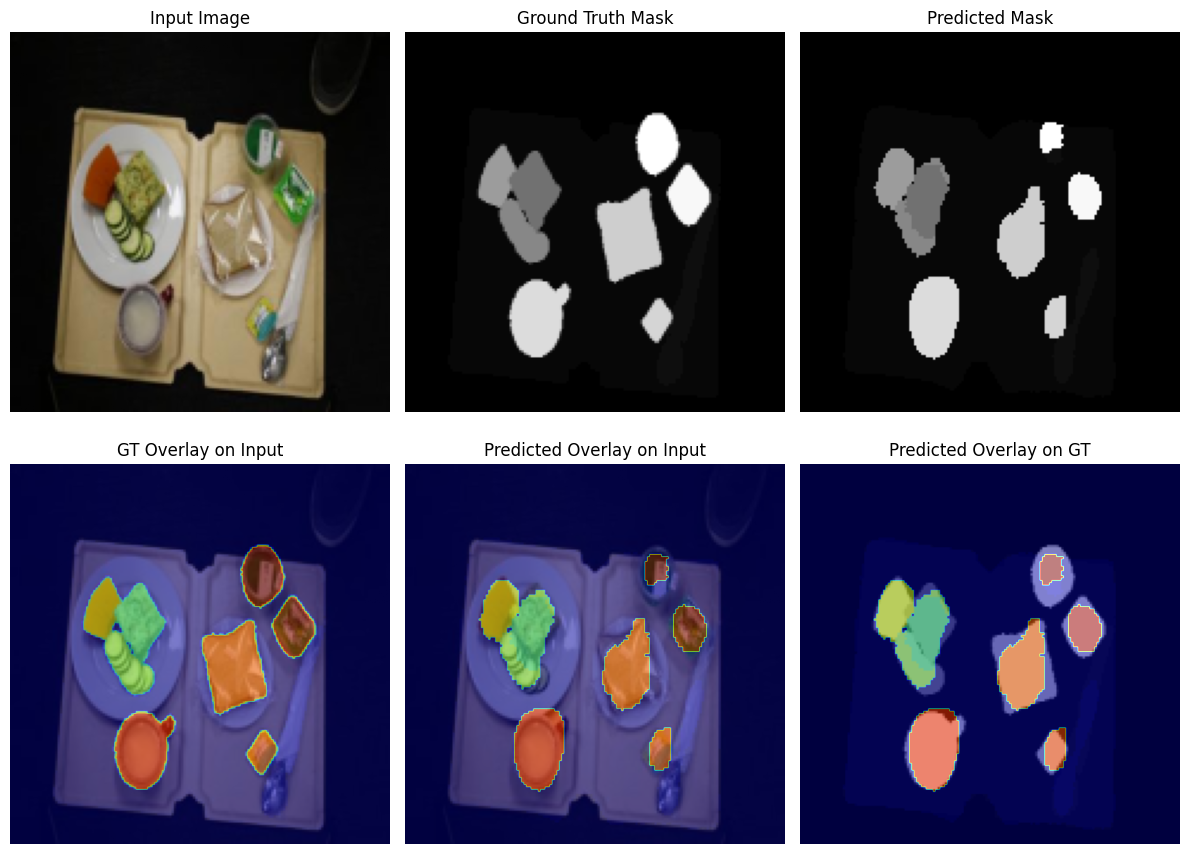

In [ ]:
  import random
  import numpy as np
  import matplotlib.pyplot as plt

  # random index
  index = random.randint(0, len(val_imgs) - 1)

  img = val_imgs[index]
  gt_mask = val_masks[index]
  pred_mask = predicted_masks[index]

  # class indices
  if pred_mask.ndim == 3:
      pred_mask = np.argmax(pred_mask, axis=-1)

  fig, axs = plt.subplots(2, 3, figsize=(12, 9))

  # First Row
  axs[0, 0].imshow(img)
  axs[0, 0].set_title('Input Image')
  axs[0, 0].axis('off')

  axs[0, 1].imshow(gt_mask, cmap='gray')
  axs[0, 1].set_title('Ground Truth Mask')
  axs[0, 1].axis('off')

  axs[0, 2].imshow(pred_mask, cmap='gray')
  axs[0, 2].set_title('Predicted Mask')
  axs[0, 2].axis('off')

  # Second Row
  axs[1, 0].imshow(img)
  axs[1, 0].imshow(gt_mask, alpha=0.5, cmap='jet')
  axs[1, 0].set_title('GT Overlay on Input')
  axs[1, 0].axis('off')

  axs[1, 1].imshow(img)
  axs[1, 1].imshow(pred_mask, alpha=0.5, cmap='jet')
  axs[1, 1].set_title('Predicted Overlay on Input')
  axs[1, 1].axis('off')

  axs[1, 2].imshow(gt_mask, cmap='gray')
  axs[1, 2].imshow(pred_mask, alpha=0.5, cmap='jet')
  axs[1, 2].set_title('Predicted Overlay on GT')
  axs[1, 2].axis('off')

  plt.tight_layout()
  plt.show()


*   What are other evaluation metrics to compare the performance of segmentation?

**Solution**

Extracted from: [sklearn](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.jaccard_score.html)

- F1 Score: Combines precision and recall into a single metric by calculating their harmonic mean; useful for balancing the trade-off between precision and recall, especially in cases of class imbalance.

- Adjusted Rand Index (ARI): Measures the similarity between the predicted segmentation and the ground truth by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true segmentations.

- Normalized Mutual Information (NMI): Assesses the mutual dependence between the predicted segmentation and the ground truth; it quantifies the amount of information shared between the two.

# Testing Model in the wild

*   Download 5 images from the internet similar to the dataset used.
*   Use the trained model to segment the images

failed to load model: File not found: filepath=path_to_root/image_segmentation_model.keras. Please ensure the file is an accessible `.keras` zip file.
model expects input size: (160, 160)
total loaded images: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


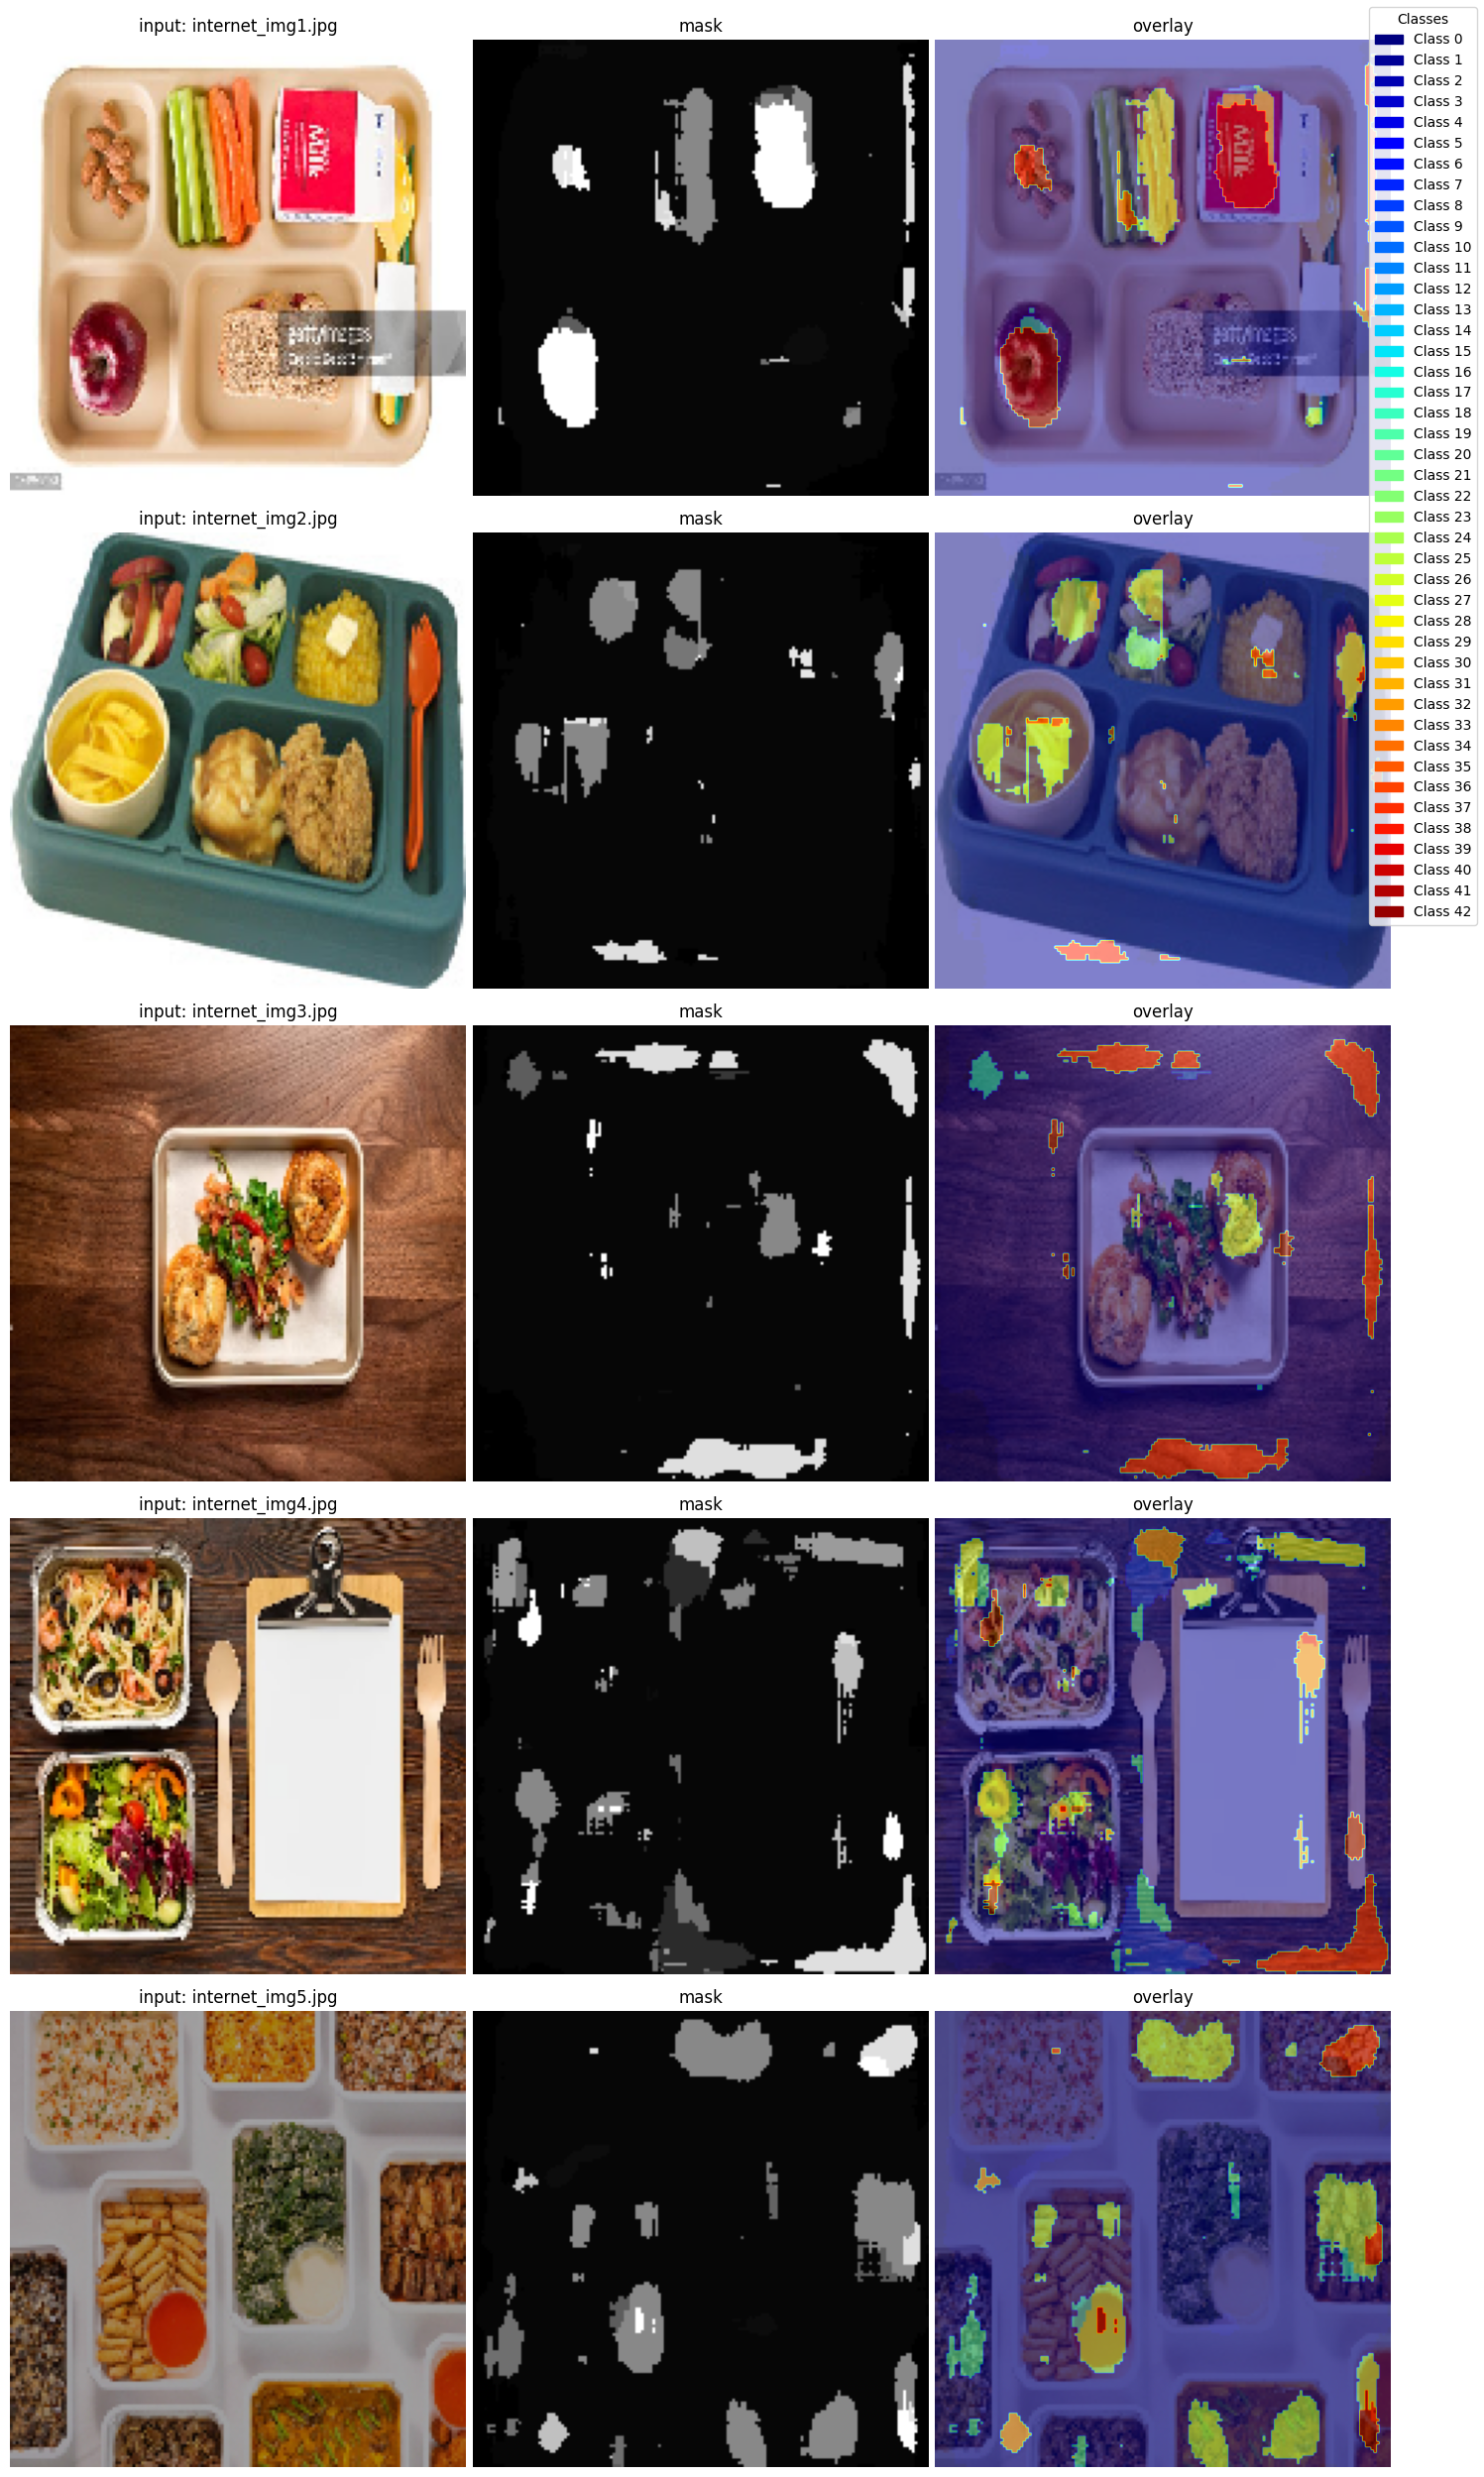

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow import keras
from tensorflow.keras.utils import load_img
import math
from matplotlib.patches import Patch  # Import Patch for legend

# define root path and load model
save_path = os.path.join(root_path, 'image_segmentation_model.keras')

try:
    model = keras.models.load_model(save_path)
    print(f"model loaded from {save_path}")
except Exception as e:
    print(f"failed to load model: {e}")
    exit(1)

# define image size expected by the model
input_size = model.input_shape[1:3]
print(f"model expects input size: {input_size}")

# paths and image names
test_image_dir = "test_images/"
image_names = [f"internet_img{i}.jpg" for i in range(1, 6)]

images = []
masks = []

# helper function to load and resize images without double resizing
def load_and_resize(image_path, size, grayscale=False):
    color_mode = "grayscale" if grayscale else "rgb"
    image = load_img(image_path, color_mode=color_mode, target_size=size)
    image = np.array(image).astype(np.float32)  # ensure float32
    return image

# load images
for name in image_names:
    img_path = os.path.join(test_image_dir, name)
    img = load_and_resize(img_path, input_size, grayscale=False)
    images.append(img)
print(f"total loaded images: {len(images)}")

# predict masks
for idx, img in enumerate(images):

    # preprocess image: no normalization
    img_batch = np.expand_dims(img, axis=0)  # add batch dimension
    img_batch = img_batch.astype(np.float32)  # ensure float32

    # predict mask
    pred_mask = model.predict(img_batch)

    # postprocess mask
    if len(pred_mask.shape) == 4:
        pred_mask = pred_mask[0]  # remove batch dimension

    pred_mask = np.argmax(pred_mask, axis=-1)

    # resize mask to original size
    original_size = (images[idx].shape[1], images[idx].shape[0])  # (width, height)
    if pred_mask.max() > 1:
        # scale to [0,255] for visualization
        pred_mask_scaled = (pred_mask / pred_mask.max() * 255).astype(np.uint8)
    else:
        pred_mask_scaled = (pred_mask * 255).astype(np.uint8)
    mask_pil = Image.fromarray(pred_mask_scaled)
    mask_pil = mask_pil.resize(original_size, resample=Image.NEAREST)
    mask_resized = np.array(mask_pil)
    masks.append(mask_resized)

# plot results
fig, axs = plt.subplots(len(masks), 3, figsize=(15, 5 * len(masks)))

for i in range(len(masks)):
    img = images[i].astype(np.uint8)
    mask = masks[i]

    # input image
    axs[i, 0].imshow(img)
    axs[i, 0].set_title(f'input: {image_names[i]}')
    axs[i, 0].axis('off')

    # mask
    axs[i, 1].imshow(mask, cmap='gray')
    axs[i, 1].set_title('mask')
    axs[i, 1].axis('off')

    # overlay
    axs[i, 2].imshow(img)
    axs[i, 2].imshow(mask, alpha=0.5, cmap='jet')
    axs[i, 2].set_title('overlay')
    axs[i, 2].axis('off')

# LEGEND
num_classes = model.output_shape[-1]
cmap = plt.cm.jet
class_colors = [cmap(i / num_classes) for i in range(num_classes)]
legend_patches = [Patch(color=class_colors[i], label=f'Class {i}') for i in range(num_classes)]
fig.legend(handles=legend_patches, loc='upper right', title='Classes')

plt.tight_layout(rect=[0, 0, 0.95, 1]) # ROOM FOR LEGEND

plt.show()


*   How accurate are the prediction masks?
*   What happens to the unlabelled classes?

**Solution**

**Question 1:**

The model performed *horribly*, with only the first test image making some sort of some; for the other ones, it often predicted background as the classes, and the masks poorly correlated with actual food.

**Question 2:**

The class predictions once again made no sense, with even some classes being predicted in an overlap fashion.

*   What are the challenges when you use a trained model in the wild?
*   How can you develop a model to be used in real world?

**Solution**

**Question 1:**

Mostly dataset bias; our dataset contained many images, but they were all likey following some underlying patterns (e.g. orientation, the color of the tray, angle). When we tried our model on the "real world", the biases our model learned which were helpful for our training data did not translate, leading to a lot of wrong predictions.

**Question 2:**

With a very big ammount of *varied* data, and trained with the real-world purpose in mind, so the test should reflect what it will be used for. Moreover, it could be beneficial to monitor model performance over time, and retrain in case it deteriorates (e.g. if the tray company changes the tray color, our model will deteriorate!)

*   What is the difference between instance segmentation and semantic segmentation?

**Solution**

Semantic segmentation classifies each pixel in an image into a predefined category without distinguishing between different instances of the same class. In contrast, instance segmentation not only assigns a class label to each pixel but also separates and identifies each individual object instance within those classes. This means that while semantic segmentation might label all cars in an image as the same category, instance segmentation would differentiate and label each car separately.

*   What is the difference between encoder and decoder? Should they be of the same type of neural network?

**Solution**

An encoder transforms input data into a compact latent representation by capturing its essential features, effectively reducing its dimensionality. Conversely, a decoder takes this latent representation and reconstructs the original data or generates the desired output from it. While encoders and decoders often use complementary neural network architectures to ensure efficient encoding and accurate decoding, they do not necessarily have to be of the same type. The choice of architecture for each component depends on the specific task and the nature of the data being processed.

For example, in U-Net, the encoder and decoder both use convolutional layers, whereas alternatively, the encoder can utilize a pretrained network like ResNet while the decoder employs specialized upsampling layers.

*   What is upsampling?

**Solution**

It is the process of increasing the spatial resolution of feature maps in neural networks. This is typically achieved using techniques such as transpose convolutions. In the context of segmentation models like U-Net, upsampling allows the network to reconstruct higher-resolution outputs from lower-resolution encoded features.

*   What are feature channels in UNet? Why is this helpful in this architecture?

**Solution**

They refer to the depth dimension of the feature maps produced by each convolutional layer. Each channel captures different aspects or patterns of the input data, allowing the network to learn a diverse set of features at various levels of abstraction. This multiplicity of feature channels is beneficial in U-Net's architecture because it enables the encoder to extract rich, detailed representations of the input image. Additionally, during the decoding process, these feature channels are combined through skip connections, which help preserve spatial information and improve the accuracy of the segmentation by providing high-resolution features alongside the upsampled data.














*   What are some applications of U-Net?

 In medical imaging, it is employed to segment tumors, organs, and cells in biomedical microscopy. It is also applied in satellite image analysis for tasks like land cover classification and agricultural monitoring, such as crop segmentation. In autonomous driving, U-Net aids in road and object segmentation, while in industrial settings, it is utilized for defect detection. Additionally, it plays a role in natural disaster assessment, such as mapping floods and other environmental changes.

*   What are the other popular semantic segmentation algorithms?
*   How are they different from each other?

**Solution**

**Question 1:**

Fully Convolutional Networks (FCNs), DeepLab (and its variants like DeepLabv3+), SegNet, Mask R-CNN, PSPNet, and HRNet. These algorithms are designed for pixel-level classification across various domains, with differences in architecture, efficiency, and accuracy depending on the task.


**Question 2:**

Mostly functionality; FCNs use fully convolutional layers for end-to-end segmentation, while DeepLab uses atrous convolutions and CRFs for refined boundaries. SegNet focuses on efficient upsampling using encoder-decoder structures. Mask R-CNN extends object detection to instance segmentation, PSPNet introduces pyramid pooling for capturing global context, and HRNet maintains high-resolution features throughout the network for fine-grained predictions.

*   What are the popular semantic segmentation datasets which are available for public access?

**Solution**

COCO-Stuff and Pascal VOC for general object and background segmentation, Cityscapes and Mapillary Vistas for urban scene understanding, and CamVid and KITTI for autonomous driving.


---

# **End of P11: Image Segmentation using UNets**

This notebook is part of **Deliverable 5**

Deadline for Deliverable 5 (P10 and P11) submission in CampusVirtual is: **Monday, the 16th of December, 2024**
